In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from utils import creat_datasets, reset_graph, grid_serach,  creating_val_data
from utils import creating_train_val_test_datasets
from layers import  bln_layer, dense_layer
from callbacks import bln_callback , tensorboard_callback, create_callback_list, save_best_model_callback


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

In [2]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
tf.__version__

'2.1.0'

### Loading data

In [4]:
random_seed = 100
minibatch = 20
buffersize = 60000
number_valid_sampels = 5000 # number of validation data
epochs = 5
learning_rate = 0.001

# 1000.0 -> 1 (all of the training dataset),  500.0 -> .5 (half of the training dataset) , 220.0-> .22 of the training dataset
number_batches_train = 1000 # number of batches to train, each batch of size of minibatch parameter
number_batches_valid = 50 # number of batches to validate, each batch of size of minibatch parameter
num_classes = 1

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)


In [5]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...


C:\Users\amira\.conda\envs\Normalization\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\amira\.conda\envs\Normalization\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [6]:
x_train, y_train, x_valid, y_valid = creating_val_data(x_train, y_train,
                                                       number_valid_sampels = number_valid_sampels,
                                                       random_seed=random_seed)

train_dataset, valid_dataset, test_dataset = creating_train_val_test_datasets(x_train, y_train,
                                                                              x_test, y_test,
                                                                              x_valid, y_valid, 
                                                                              minibatch = minibatch,
                                                                              buffersize= buffersize,
                                                                              random_seed=random_seed)

In [7]:
train_dataset

<PrefetchDataset shapes: ((20, 80), (20,)), types: (tf.int32, tf.int64)>

# 1. Using Batch Layer Normalization Layer

In [9]:
def BLNLayer_model(inputshape= (80), max_features = 20000, embed_size=128, random_seed = 100,
                          lstm_unit = 128 , dense_units= 1,
                          batch_size = 10,
                          b_mm = True, b_mv = True,
                          f_mm = False, f_mv = False):
    

    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
    x = Embedding(max_features, embed_size,
                  embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(input_lyr)
    
    x = LSTM(lstm_unit, dropout=0.2, recurrent_dropout=0.2,activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=True)(x)
    
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn1', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x) 
    
    x = LSTM(lstm_unit//2, dropout=0.2,  recurrent_dropout=0.2,activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=False)(x)
    
    
    x = bln_layer(stateful = True, batchsize= batch_size, name = 'bn2', 
                  batch_moving_mean = b_mm, batch_moving_var = b_mv,
                  feature_moving_mean = f_mm, feature_moving_var = f_mv)(x) 
    
    output_lyr = dense_layer(units = dense_units, name = 'dense1', random_seed=random_seed)(x)    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [10]:
model_bln_layer = BLNLayer_model(inputshape= (80), max_features = max_features, 
                                        embed_size= 128, random_seed = random_seed,
                                        lstm_unit = 128 , dense_units= num_classes,
                                        batch_size = minibatch,
                                        b_mm = True, b_mv = True,
                                        f_mm = False, f_mv = False
                                        )



In [11]:
model_bln_layer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 80)]                0         
_________________________________________________________________
embedding (Embedding)        (20, 80, 128)             2560000   
_________________________________________________________________
lstm (LSTM)                  (20, 80, 128)             131584    
_________________________________________________________________
bn1 (bln_layer)              (20, 80, 128)             23938     
_________________________________________________________________
lstm_1 (LSTM)                (20, 64)                  49408     
_________________________________________________________________
bn2 (bln_layer)              (20, 64)                  298       
_________________________________________________________________
dense1 (dense_layer)         (20, 1)                   65    

# callbacks

In [12]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_bln_layer_TTFF_imdb'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

# Callback for resetting moving mean and variances at the end of each epoch
bln_layer_cb = bln_callback()

bln_layer_cb_list = create_callback_list(save_bm_cb, tb_cb, bln_layer_cb)

In [13]:
model_bln_layer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                               loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                               metrics = [tf.keras.metrics.BinaryAccuracy()])

In [14]:
model_bln_layer_history =  model_bln_layer.fit(train_dataset.take(number_batches_train), epochs=epochs,
                                                verbose=1, callbacks=bln_layer_cb_list,
                                                validation_data=valid_dataset.take(number_batches_valid),
                                                shuffle=True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 362s 724ms/step - loss: 0.5155 - binary_accuracy: 0.7265 - val_loss: 0.4525 - val_binary_accuracy: 0.7850
Epoch 2/5
500/500 [==============================] - 378s 756ms/step - loss: 0.3081 - binary_accuracy: 0.8715 - val_loss: 0.6340 - val_binary_accuracy: 0.7470
Epoch 3/5
500/500 [==============================] - 377s 755ms/step - loss: 0.1926 - binary_accuracy: 0.9290 - val_loss: 0.6061 - val_binary_accuracy: 0.7580
Epoch 4/5
500/500 [==============================] - 386s 773ms/step - loss: 0.1309 - binary_accuracy: 0.9518 - val_loss: 0.6262 - val_binary_accuracy: 0.7850
Epoch 5/5
500/500 [==============================] - 368s 736ms/step - loss: 0.1123 - binary_accuracy: 0.9571 - val_loss: 0.6651 - val_binary_accuracy: 0.7690


In [15]:
weights_path = "./models/" + folder_name + '/'+ str(number_batches_train) +"_pretrained_weights_TTFF.h5"
model_bln_layer.save_weights(weights_path)

In [16]:
del model_bln_layer, save_bm_cb, tb_cb, bln_layer_cb, bln_layer_cb_list
reset_graph()

session is clear


In [17]:
save_eval_path = "./logs/" + folder_name + '/'+ str(number_batches_train) +"_sorted_evaluation.pkl"
evaluation = grid_serach(BLNLayer_model, test_dataset,
                         batch_size = minibatch, sort=True,
                         save_eval_path = save_eval_path,
                         weights_path = weights_path,
                         loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics = tf.keras.metrics.BinaryAccuracy())



1250/1250 [==============================] - 358s 286ms/step - loss: 0.6346 - binary_accuracy: 0.7854
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.6346097180426121, 0.78536]}
session is clear
1250/1250 [==============================] - 362s 290ms/step - loss: 0.6411 - binary_accuracy: 0.7841
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.6346097180426121, 0.78536], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.6410765636846423, 0.78412]}
session is clear
1250/1250 [==============================] - 358s 286ms/step - loss: 0.6343 - binary_accuracy: 0.7854
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.6346097180426121, 0.78536], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.6410765636846423, 0.78412], 'Bmm_True Bmv_True Fmm_False Fmv_True': [0.6342640895679593, 0.78536]}
session is clear
1250/1250 [==============================] - 354s 283ms/step - loss: 0.6406 - binary_accuracy: 0.7840
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.6346097180426121, 0.78536], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.6

1250/1250 [==============================] - 352s 282ms/step - loss: 0.7360 - binary_accuracy: 0.7726
{'Bmm_True Bmv_True Fmm_True Fmv_True': [0.6346097180426121, 0.78536], 'Bmm_True Bmv_True Fmm_True Fmv_False': [0.6410765636846423, 0.78412], 'Bmm_True Bmv_True Fmm_False Fmv_True': [0.6342640895679593, 0.78536], 'Bmm_True Bmv_True Fmm_False Fmv_False': [0.6405762285396457, 0.784], 'Bmm_True Bmv_False Fmm_True Fmv_True': [0.7500201662614941, 0.78072], 'Bmm_True Bmv_False Fmm_True Fmv_False': [0.7574760594069958, 0.78048], 'Bmm_True Bmv_False Fmm_False Fmv_True': [0.7495505352556705, 0.78072], 'Bmm_True Bmv_False Fmm_False Fmv_False': [0.7568002015382052, 0.78044], 'Bmm_False Bmv_True Fmm_True Fmv_True': [0.6248436477184296, 0.77592], 'Bmm_False Bmv_True Fmm_True Fmv_False': [0.6314860007792711, 0.7758], 'Bmm_False Bmv_True Fmm_False Fmv_True': [0.6244417284399271, 0.776], 'Bmm_False Bmv_True Fmm_False Fmv_False': [0.6308254452496767, 0.77596], 'Bmm_False Bmv_False Fmm_True Fmv_True': [

In [2]:
evaluation 

[('Bmm_False Bmv_True Fmm_False Fmv_True', [0.6244417284399271, 0.791]),
 ('Bmm_False Bmv_True Fmm_True Fmv_True', [0.6248436477184296, 0.77592]),
 ('Bmm_False Bmv_True Fmm_False Fmv_False', [0.6308254452496767, 0.77596]),
 ('Bmm_False Bmv_True Fmm_True Fmv_False', [0.6314860007792711, 0.7758]),
 ('Bmm_True Bmv_True Fmm_False Fmv_True', [0.6342640895679593, 0.78536]),
 ('Bmm_True Bmv_True Fmm_True Fmv_True', [0.6346097180426121, 0.78536]),
 ('Bmm_True Bmv_True Fmm_False Fmv_False', [0.6405762285396457, 0.784]),
 ('Bmm_True Bmv_True Fmm_True Fmv_False', [0.6410765636846423, 0.78412]),
 ('Bmm_False Bmv_False Fmm_False Fmv_True', [0.7359723214775323, 0.77256]),
 ('Bmm_False Bmv_False Fmm_True Fmv_True', [0.7364888896733522, 0.77248]),
 ('Bmm_False Bmv_False Fmm_False Fmv_False', [0.7433640133857727, 0.77212]),
 ('Bmm_False Bmv_False Fmm_True Fmv_False', [0.744176055303216, 0.77216]),
 ('Bmm_True Bmv_False Fmm_False Fmv_True', [0.7495505352556705, 0.78072]),
 ('Bmm_True Bmv_False Fmm_True 

# 2.Using  Batch Normalization implemented in Keras

In [25]:
def bn_keras_model(inputshape= (80), max_features = 20000, embed_size=128, random_seed = 100,
                          lstm_unit = 128 , dense_units= 1,
                          batch_size = 60):
    

    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
    x = Embedding(max_features, embed_size,
                  embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(input_lyr)
    
    x = LSTM(lstm_unit, dropout=0.2, recurrent_dropout=0.2, activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=True)(x)
    
    x =  tf.keras.layers.BatchNormalization(momentum = 0.99,  name = 'bn1') (x) 
    
    x = LSTM(lstm_unit//2, dropout=0.2,  recurrent_dropout=0.2, activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=False)(x)
    
    x =  tf.keras.layers.BatchNormalization(momentum = 0.99,  name = 'bn2') (x) 

    
    output_lyr = dense_layer(units = dense_units, name = 'dense1', random_seed=random_seed)(x)    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])


In [26]:
model_bn_keras = bn_keras_model(inputshape= (80), max_features = max_features, 
                                embed_size= 128, random_seed = random_seed,
                                lstm_unit = 128 , dense_units= num_classes,
                                batch_size = minibatch)
model_bn_keras.summary()

#### Compiling 
model_bn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics = [tf.keras.metrics.BinaryAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 80)]                0         
_________________________________________________________________
embedding (Embedding)        (20, 80, 128)             2560000   
_________________________________________________________________
lstm (LSTM)                  (20, 80, 128)             131584    
_________________________________________________________________
bn1 (BatchNormalization)     (20, 80, 128)             512       
_________________________________________________________________
lstm_1 (LSTM)                (20, 64)                  49408     
_________________________________________________________________
bn2 (BatchNormalization)     (20, 64)                  256       
_________________________________________________________________
dense1 (dense_layer)         (20, 1)                   65    

In [27]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_bn_Keras_imdb'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)


bn_keras_cb_list = [save_bm_cb, tb_cb]

In [28]:
model_bn_keras_history =  model_bn_keras.fit(train_dataset.take(number_batches_train),
                                             epochs = epochs, verbose=1, 
                                             callbacks = bn_keras_cb_list,
                                             validation_data = valid_dataset.take(number_batches_valid),
                                             shuffle = True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 370s 740ms/step - loss: 0.5463 - binary_accuracy: 0.7076 - val_loss: 0.6746 - val_binary_accuracy: 0.7100
Epoch 2/5
500/500 [==============================] - 388s 775ms/step - loss: 0.3608 - binary_accuracy: 0.8364 - val_loss: 0.5634 - val_binary_accuracy: 0.7370
Epoch 3/5
500/500 [==============================] - 391s 782ms/step - loss: 0.2392 - binary_accuracy: 0.9034 - val_loss: 0.6374 - val_binary_accuracy: 0.7780
Epoch 4/5
500/500 [==============================] - 364s 727ms/step - loss: 0.1690 - binary_accuracy: 0.9351 - val_loss: 0.6599 - val_binary_accuracy: 0.7680
Epoch 5/5
500/500 [==============================] - 361s 721ms/step - loss: 0.1236 - binary_accuracy: 0.9551 - val_loss: 0.7111 - val_binary_accuracy: 0.7790


In [29]:
model_bn_keras_test_history = model_bn_keras.evaluate(test_dataset)

1250/1250 [==============================] - 364s 291ms/step - loss: 0.6873 - binary_accuracy: 0.7731


[0.6872664474546909, 0.77312]

In [ ]:
del model_bn_keras, save_bm_cb, tb_cb, bn_keras_cb_list 
reset_graph()

# 3.Using  Layer normalization  implemented in Keras


In [31]:
def ln_keras_model(inputshape= (80), max_features = 20000, embed_size=128, random_seed = 100,
                          lstm_unit = 128 , dense_units= 1,
                          batch_size = 60):
    

    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=batch_size, name = 'input')
    
    x = Embedding(max_features, embed_size,
                  embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=random_seed))(input_lyr)
    
    x = LSTM(lstm_unit, dropout=0.2, recurrent_dropout=0.2, activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=True)(x)
    
    x =  tf.keras.layers.LayerNormalization()(x) 

    x = LSTM(lstm_unit//2, dropout=0.2,  recurrent_dropout=0.2, activation='tanh',
            recurrent_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed),
            kernel_initializer = tf.keras.initializers.GlorotUniform(seed=random_seed) ,
            return_sequences=False)(x)
    
    x =  tf.keras.layers.LayerNormalization()(x) 

    
    output_lyr = dense_layer(units = dense_units, name = 'dense1', random_seed=random_seed)(x)    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])



In [32]:
model_ln_keras = ln_keras_model(inputshape= (80), max_features = max_features, 
                                embed_size= 128, random_seed = random_seed,
                                lstm_unit = 128 , dense_units= num_classes,
                                batch_size = minibatch)
model_ln_keras.summary()

#### Compiling 
model_ln_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics = [tf.keras.metrics.BinaryAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(20, 80)]                0         
_________________________________________________________________
embedding (Embedding)        (20, 80, 128)             2560000   
_________________________________________________________________
lstm (LSTM)                  (20, 80, 128)             131584    
_________________________________________________________________
layer_normalization (LayerNo (20, 80, 128)             256       
_________________________________________________________________
lstm_1 (LSTM)                (20, 64)                  49408     
_________________________________________________________________
layer_normalization_1 (Layer (20, 64)                  128       
_________________________________________________________________
dense1 (dense_layer)         (20, 1)                   65    

In [33]:
# Callbacks for saving best model and tensorboard
folder_name = str(number_batches_train) + '_ln_Keras_imdb'
save_bm_cb = save_best_model_callback(folder_name)
tb_cb = tensorboard_callback(folder_name)

ln_keras_cb_list = [save_bm_cb, tb_cb]

In [34]:
model_ln_keras_history =  model_ln_keras.fit(train_dataset.take(number_batches_train),
                                             epochs=epochs, verbose=1, 
                                             callbacks=ln_keras_cb_list,
                                             validation_data=valid_dataset.take(number_batches_valid),
                                             shuffle=True)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 362s 724ms/step - loss: 0.5407 - binary_accuracy: 0.7026 - val_loss: 0.4623 - val_binary_accuracy: 0.7580
Epoch 2/5
500/500 [==============================] - 361s 723ms/step - loss: 0.2711 - binary_accuracy: 0.8874 - val_loss: 0.4589 - val_binary_accuracy: 0.7840
Epoch 3/5
500/500 [==============================] - 367s 734ms/step - loss: 0.1751 - binary_accuracy: 0.9326 - val_loss: 0.4799 - val_binary_accuracy: 0.7950
Epoch 4/5
500/500 [==============================] - 373s 746ms/step - loss: 0.1174 - binary_accuracy: 0.9566 - val_loss: 0.5854 - val_binary_accuracy: 0.7640
Epoch 5/5
500/500 [==============================] - 360s 720ms/step - loss: 0.0799 - binary_accuracy: 0.9716 - val_loss: 0.6458 - val_binary_accuracy: 0.7900


In [35]:
model_ln_keras_test_history = model_ln_keras.evaluate(test_dataset)

1250/1250 [==============================] - 368s 294ms/step - loss: 0.6488 - binary_accuracy: 0.7826


[0.6487908877536654, 0.7826]

In [36]:
del model_ln_keras,save_bm_cb, ln_keras_cb_list
reset_graph()

session is clear


# 4. Make Comaprison 
#### Layer Normalization, Batch Normalization and Batch Layer Normalization


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


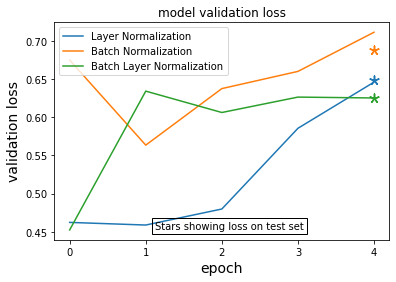

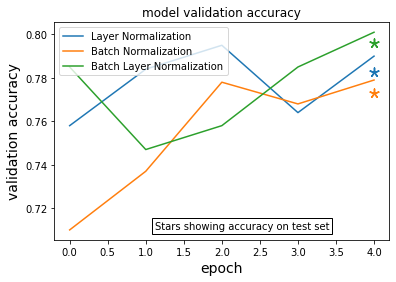

In [60]:
# list all data in history
print(model_ln_keras_history.history.keys())
# summarize history for accuracy


plt.figsize=(12, 12)
plt.plot(model_ln_keras_history.history['val_loss'])
plt.plot(model_bn_keras_history.history['val_loss'])
plt.plot(model_bln_layer_history.history['val_loss'])
plt.scatter(4, model_ln_keras_test_history[0], s=80,  marker=(5, 2))
plt.scatter(4, model_bn_keras_test_history[0], s=80,  marker=(5, 2))
plt.scatter(4,evaluation[0][1][0], s=80,  marker=(5, 2))
plt.xticks(np.arange(0, 5, 1))

plt.title('model validation loss')
plt.ylabel('validation loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['Layer Normalization', 'Batch Normalization','Batch Layer Normalization' ], loc='upper left')
ax = plt.gca()
ax.text(0.3,0.05,'Stars showing loss on test set',transform=ax.transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'))
plt.show()


plt.plot(model_ln_keras_history.history['val_binary_accuracy'])
plt.plot(model_bn_keras_history.history['val_binary_accuracy'])
plt.plot(model_bln_layer_history.history['val_binary_accuracy'])
plt.scatter(4, model_ln_keras_test_history[1], s=80,  marker=(5, 2))
plt.scatter(4, model_bn_keras_test_history[1], s=80,  marker=(5, 2))
plt.scatter(4, evaluation[0][1][1], s=80,  marker=(5, 2))
#plt.xticks(np.arange(0, 5, 1))
#plt.yticks(np.arange(0.2, .6, .05))

plt.title('model validation accuracy')
plt.ylabel('validation accuracy', fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['Layer Normalization', 'Batch Normalization','Batch Layer Normalization' ], loc='upper left')
ax = plt.gca()
ax.text(0.3,0.05,'Stars showing accuracy on test set',transform=ax.transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'))
plt.show()

